# **Lung Cancer Classification using Computerized Tomography (CT) Data**  
<div style="text-align: center;">
    <img src="images/portrait.png" alt="CT Lung Image" style="width:100%; height:50%;">
</div>


## **Abstract**
Lung cancer remains one of the leading causes of cancer-related deaths worldwide, primarily due to late-stage diagnoses. Early detection through imaging technologies like Computerized Tomography (CT) scans has been shown to significantly improve patient outcomes. The objective of this notebook is to develop an efficient classification system to predict the condition of patients by analyzing CT scan data, thereby facilitating early detection of lung cancer.

To achieve this, we utilize a combination of traditional Machine Learning techniques alongside semi-supervised algorithms, augmenting data and ensuring the robustness and accuracy of the model.


## **Introduction**

### Context of the Problem
Lung cancer is one of the deadliest types of cancer, responsible for millions of deaths globally each year. The prognosis for patients with lung cancer greatly depends on the stage at which the disease is detected. Unfortunately, most lung cancer cases are diagnosed at an advanced stage, limiting treatment options and reducing survival rates. Early detection is crucial in improving patient outcomes, as it allows for timely interventions and a broader range of treatment strategies.

Computerized Tomography (CT) scans play a key role in lung cancer diagnosis. CT imaging provides detailed, cross-sectional views of the lungs, allowing physicians to detect abnormalities such as tumors, nodules, or tissue damage. However, the manual analysis of CT images is time-consuming, subject to human error, and dependent on the expertise of the radiologist. Therefore, automating the classification of lung cancer from CT images using Machine Learning (ML) and Deep Learning (DL) offers significant potential to enhance diagnostic accuracy and efficiency.

### Objective of the Work
This notebook aims to build a robust classification model for detecting lung cancer based on CT scan images. By leveraging Machine Learning techniques , we aim to automatically classify CT images as cancerous or non-cancerous. The primary goal is to provide an automated, reliable, and scalable solution to aid in the early detection of lung cancer, thereby improving patient prognosis.

### Structure of the Work
This notebook is structured as follows:

- Data Exploration and Preprocessing: We begin by exploring the dataset, including a detailed visualization of the CT images to gain insights into the structure and distribution of the data. The preprocessing phase involves essential Computer Vision steps such as image normalization to standardize pixel intensity values and segmentation to isolate regions of interest (e.g., lung nodules), which are critical for enhancing model performance and improving feature extraction. Additionally, we apply semi-supervised learning techniques to refine the dataset, leveraging unlabeled/uncertain data to improve the overall quality and representativeness of the training set.

- Semi-Supervised: Inductive and transductive semi-supervised methods are tested and used to enhance data quality (e.g. Label Spreading, SMOTE,GMM)

- Model Development: Next, we build and train various classification models(traditional ML algorithms) comparing their performance across different metrics.

- Evaluation and Results: The performance of the models will be assessed using key metrics such as accuracy, precision, recall, and the AUC-ROC curve. Once the best-performing model is identified, we apply hyperparameter tuning techniques to further optimize its performance and maximize its predictive effectiveness.

- Discussion and Future Work: Finally, we will discuss the results, highlighting the strengths and limitations of our approach, and propose potential improvements or future research directions for lung cancer classification using medical imaging.

## **Exploratory Data Analysis(EDA)**
To enhance data visualization and exploration, a custom classes will be developed. This class will implement methods for nodule visualization, querying, and radiomics extraction, which will facilitate subsequent analysis and research.

*Disclaimer: Certain functions in the PyLIDC library, which rely on external packages such as **Numpy, Scikit-learn, and Matplotlib**, among others, have been slightly modified to address compatibility issues arising from deprecated versions.*


In [51]:
import pylidc as pl
import numpy as np
import matplotlib.pyplot as plt
from radiomics.featureextractor import *
import medpy
from sklearn.cluster import KMeans
import matplotlib.animation as manim
from skimage.measure import find_contours
from pylidc.utils import consensus
from Nodule import LIDCBase, PyLIDC

The **LIDC-IDRI** dataset consists of over 1,000 thoracic CT scans from patients, with a primary focus on detecting and analyzing lung nodules. A unique feature of this dataset is the detailed nodule annotations provided by four experienced thoracic radiologists. Each radiologist independently marked and classified nodules, allowing for up to four distinct annotations per nodule. Only nodules larger than 3 mm were included, as these are clinically significant for lung cancer screening. The annotations capture important information for training machine learning models, such as the nodule’s location, volume, sphericity, texture, and other relevant characteristics.

The *PyLidc* module facilitates the processing of these annotations, which are stored in XML format, and provides tools for visualizing the data, making it easier to extract features and prepare it for model development. Below is a practical example of how this module can be used to process and visualize the data:

In [52]:
l = PyLIDC('LIDC-IDRI-0001') # Lets use patient number 1 for the demonstration
l.get_nodule_count() # Number of nodules shown
l.summary() # Some stats
print("")
print("Accessing first nodule annotations...")
nods = l.get_nodules() # Nodules
anns = nods[0] # First, and in this case unique nodule
anns

Patient ID: LIDC-IDRI-0001
Number of nodules: 1
Loading dicom files ... This may take a moment.
Scan dimensions (voxels): (512, 512, 133)
Pixel spacing (mm): 0.703125
Slice thickness (mm): 2.5

Accessing first nodule annotations...


[Annotation(id=84,scan_id=12),
 Annotation(id=85,scan_id=12),
 Annotation(id=86,scan_id=12),
 Annotation(id=87,scan_id=12)]

As demonstrated above, the first patient's nodule has been annotated by four radiologists, allowing us to visualize 2D and 3D these annotations on a specific CT slice. From these annotations, we can extract valuable data, including nodule characteristics such as size, volume, and sphericity,  essential for further analysis.

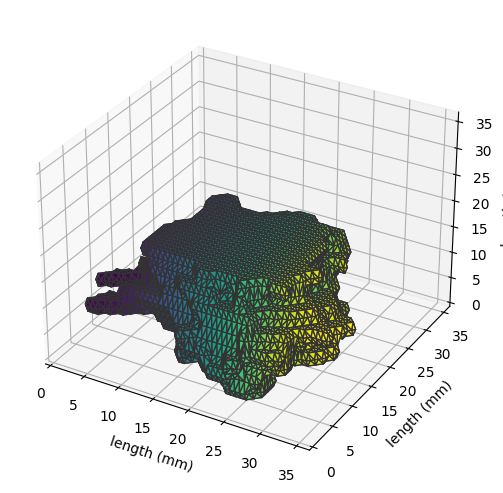

Loading dicom files ... This may take a moment.


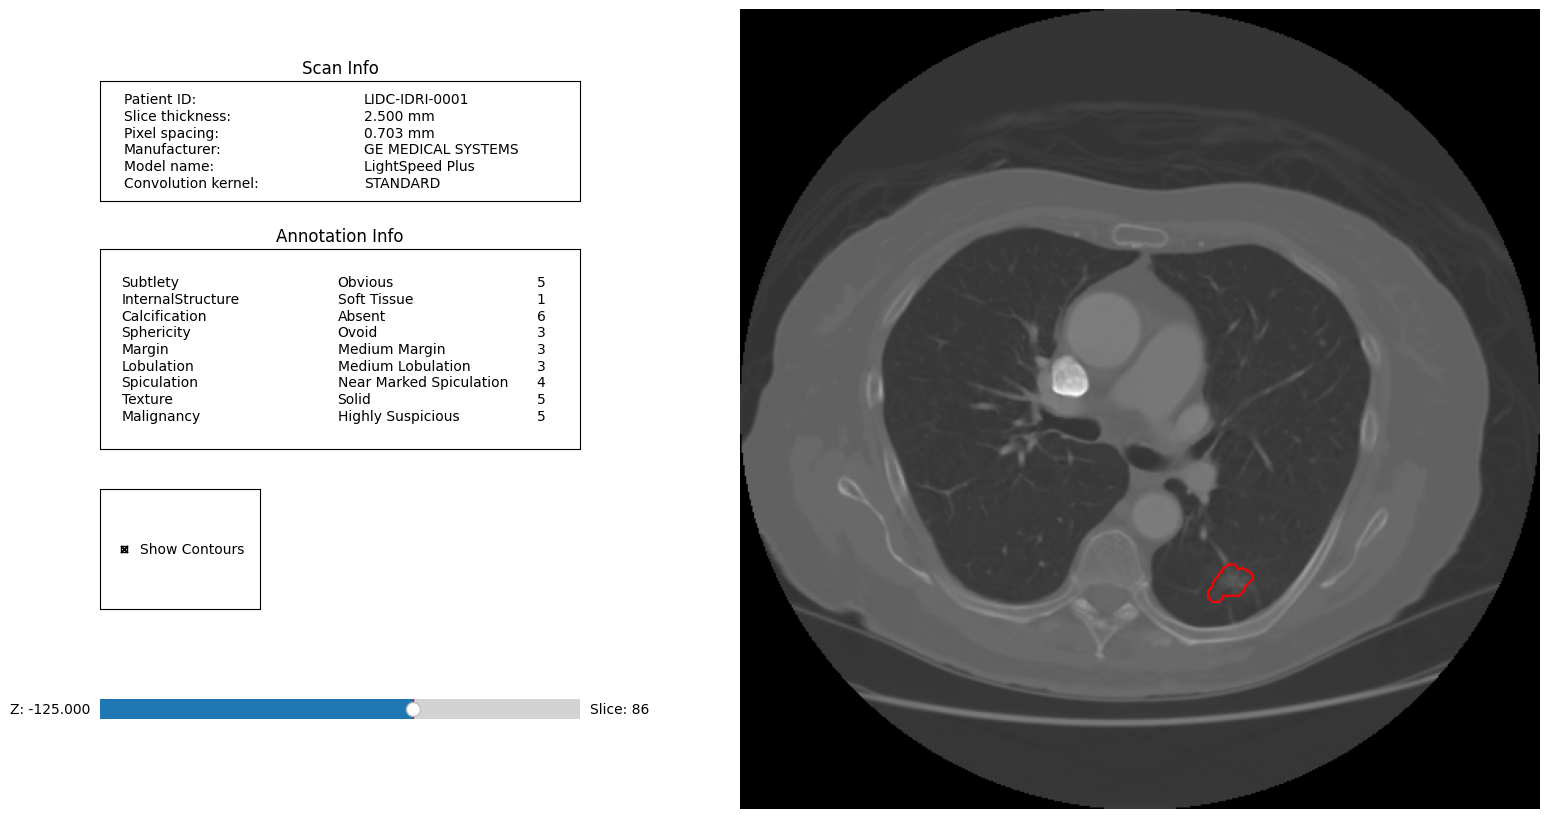

Sphericity: 3.0000
Volume: 7869.37 cubic mm
Surface area: 2801.43 square mm
Average texture score: 5
Calcification: 6


In [53]:
first_annotation = anns[0]
first_annotation.visualize_in_3d()
first_annotation.visualize_in_scan()
# Extract relevant features 
print(f"Sphericity: {first_annotation.sphericity:.4f}")
print(f"Volume: {first_annotation.volume:.2f} cubic mm")
print(f"Surface area: {first_annotation.surface_area:.2f} square mm")
print(f"Average texture score: {first_annotation.texture}")
print(f"Calcification: {first_annotation.calcification}")



This process will be repeated iteratively across the entire dataset to ensure the creation of a comprehensive and reliable dataset. The next step involves analyzing and exploring the patterns and consistency of the annotations provided by the radiologists to better understand their behavior and inter-observer variability.

In [ ]:
from data_viz import plot_all_patients_annotations

plot_all_patients_annotations(plot = False)



<div style="text-align: center;">
    <img src="images/anotation_properties.png" alt="Annotation Prop">
</div>


From the graph shown above, we can conclude that the annotations are **not evenly distributed**. If we observe closely, we can see how the surface area, diameter, and volume of the nodules seem to be somewhat related, as all three display a slightly left-skewed graph, especially the diameter.

On the other hand, we can see that the predominant texture of the nodules is solid, but with a soft-tissue internal structure and lacking calcification.

Finally, it is important to note in the Malignancy rating graph that most of the nodule annotations are ambiguous, which often implies that **classifying nodules is not an easy task**, even for professionals in the field.

### **Hounsfield Units(HU)**
Texture plays a crucial role in identifying malignant nodules, as we will further explore below. It can provide significant insight into the internal composition of a nodule, helping differentiate between benign and malignant characteristics. In CT scans, pixel values are represented in Hounsfield Units (HU), which measure the density of tissues. This allows for a more precise analysis of the nodule's texture by distinguishing between soft tissue, calcifications, and other structures based on their specific HU values.
$$HU(x,y) \equiv 1000 \cdot \frac{\mu(x,y) - \mu_{\text{water}}}{\mu_{\text{water}}-\mu_\text{air}}$$

where $\mu$ is the linear attenuation coefficient of the material. The linear attenuation coefficient is defined based on how the intensity of a photon beam decays as it passes a distance $x$ through a material $I=I_0e^{-\mu x}$. Note that $\mu$ depends on the energy of the photon beam, and in a CT scan photons usually have energies $\approx 100$ keV. Here are typical HU values:
<div style="text-align: center;">
    <img src="images/HU_table.jpg" alt="HU Table">
</div>



For this case, we have arbitrarily set the range of **HU (Hounsfield Unit)** values. Specifically, we are using a range from **-1000 to 400**, as this range appears reasonable based on reference tables. It effectively captures key tissue types such as calcifications, fat, fluids, muscles, and even bones, making it potentially useful for detecting malignant nodules. An image example is shown below:

In [2]:
import pydicom
import numpy as np
# Read DICOM file
from pathlib import Path

from utils import convert_to_HU,clip_hu_range,normalize_hu

# Define the directory of the LIDC-IRDI files. For now we will work with just one random CT slice
directory = Path(r"LIDC-IDRI\LIDC-IDRI-0002\1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160200744295382098329")

# Iterate over the files of this directory 
for idx,archive in enumerate(directory.rglob('*')):

    if archive.is_file() and idx<=1: # Ignorar directorys
        # HU conversion from pixels
        hu_image = convert_to_HU(archive)

        # Cap HU units
        clipped_image = clip_hu_range(hu_image)

        # Normalize
        """
        normalized_image = normalize_hu(clipped_image)
        plt.pcolormesh(normalized_image, cmap='gray')
        plt.title("CT Normalized Image")
        plt.show()
        """
        
        

<div style="text-align: center;">
    <img src="images/hu_image_sample.png" alt="HU CT Sample">,<img src="images/hu_image_sample2.png" alt="HU CT Sample2">
</div>

### **Wavelets**
Wavelets are powerful mathematical tools used in signal processing and image analysis. Unlike traditional Fourier transforms, which break down signals into infinite sinusoidal waves, wavelets allow us to decompose signals into small, localized wave-like components. This makes wavelets particularly well-suited for analyzing non-stationary signals or signals that have transient or abrupt changes, such as medical images where detail, texture, and edges are crucial.

There are several families of wavelets, each with different characteristics. In this case, we will use **Haar**, as they are widely used in medical imaging due to their ability to capture both fine and coarse details efficiently, while maintaining low computational requirements. Besides, they have presented the best results empirically.

Daubechies db4 wavelets are computed by first applying low-pass and high-pass filters to the image to separate low-frequency (approximation) and high-frequency (detail) components. These filtered signals are then downsampled (reducing the data size by half), and the process is repeated for the approximation component at multiple scales to capture different levels of detail. This hierarchical decomposition enables multiresolution analysis, making wavelets ideal for complex image processing tasks.

In [55]:
import pywt
import cv2
import matplotlib.pyplot as plt

# Load a grayscale CT scan image (replace 'CT_scan_example.png' with your image path)
image = cv2.imread('images/lung.png', cv2.IMREAD_GRAYSCALE)
coeffs = pywt.wavedec2(image, 'haar', level=3)

# Extract approximation and detail coefficients 
cA, (cH, cV, cD) = coeffs[0], coeffs[-1]

"""
# Display the approximation and detail components
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.imshow(cA, cmap='gray')
plt.title('Approximation Coefficients')

plt.subplot(1, 4, 2)
plt.imshow(cH, cmap='gray')
plt.title('Horizontal Detail Coefficients')

plt.subplot(1, 4, 3)
plt.imshow(cV, cmap='gray')
plt.title('Vertical Detail Coefficients')

plt.subplot(1, 4, 4)
plt.imshow(cD, cmap='gray')
plt.title('Diagonal Detail Coefficients')

plt.show()

"""

"\n# Display the approximation and detail components\nplt.figure(figsize=(12, 6))\nplt.subplot(1, 4, 1)\nplt.imshow(cA, cmap='gray')\nplt.title('Approximation Coefficients')\n\nplt.subplot(1, 4, 2)\nplt.imshow(cH, cmap='gray')\nplt.title('Horizontal Detail Coefficients')\n\nplt.subplot(1, 4, 3)\nplt.imshow(cV, cmap='gray')\nplt.title('Vertical Detail Coefficients')\n\nplt.subplot(1, 4, 4)\nplt.imshow(cD, cmap='gray')\nplt.title('Diagonal Detail Coefficients')\n\nplt.show()\n\n"

<div style="text-align: center;">
    <img src="images/wavelets.png" alt="HaarWavelet">
</div>

Wavelets have a wide range of applications beyond computer vision, including but not limited to feature extraction, segmentation, and noise reduction. They are also employed in fields such as time-series analysis for denoising and in various other applications, including audio processing and data compression. In this particular study, while **wavelets will not be utilized directly in the model** , their implementation could significantly enhance the robustness and performance of trained models. By capturing localized features and managing noise more effectively, wavelet transforms can provide a richer representation of the data, potentially leading to improved classification accuracy and generalization capabilities.

## **Dataset Preparation**
After conducting a thorough analysis of the data, we will proceed with the construction of the dataset, which will serve as the foundation for training machine learning models. Our primary objective is to **predict the benignity of a nodule** based on features annotated by radiologists, as well as characteristics extracted from the images. Examples of features that can be extracted include texture measures, shape descriptors, and statistical metrics such as intensity histograms.

To achieve this, we will utilize statistical summaries of the annotations and the CT slices, primarily focusing on metrics like the mean, which will aid in estimating the location of the nodule. This estimation will be crucial for generating the corresponding mask and for determining its associated features.

### **Mask Extraction**
To extract information from the images, we must first segment the nodules. We will employ the *consensus* function from the *PyLidc* library (based on 50% radiologist agreement) to delineate the nodule boundaries. Subsequently, we will utilize relevant CT slices along with their corresponding nodule masks to extract key characteristics.

In [ ]:
from pathlib import Path  
from utils import  segment_lung,calculate_malignancy
import seaborn as sns
from Mask import process_nodule_images_masks

# Para nombrar cada imagen y máscara
prefix = [str(x).zfill(3) for x in range(1000)]

scan = pl.query(pl.Scan) # Iterate through all patients

for sc in scan : 
    nodules_annotation_list = sc.cluster_annotations()  
    vol = sc.to_volume()  # Convierte el escaneo a un volumen numpy
    print("Patient ID: {} Dicom Shape: {} Number of Annotated Nodules: {}".format(sc.patient_id, vol.shape, len(nodules_annotation_list)))
    
    process_nodule_images_masks(pid=sc.patient_id, 
                            nodules_annotation = nodules_annotation_list, 
                            vol = vol, 
                            consensus_func = consensus, 
                            calculate_malignancy_func = calculate_malignancy,
                            prefix = prefix)





In [56]:
from data_viz import plot_CT

# Cargar el archivo .npy
file_path = r"data\image\LIDC-IDRI-0110\0110_NI001_slice048.npy" # Reemplaza con la ruta a tu archivo
data = np.load(file_path)

# Cargar el archivo .npy
file_path2 = r"data\mask\LIDC-IDRI-0110\0110_MA001_slice048.npy" # Reemplaza con la ruta a tu archivo
data2 = np.load(file_path2)


# Imprimir la forma del arreglo
print("Forma de los arreglos:", data.shape, data2.shape)

#plot_CT(data), plot_CT(data2), plot_CT(data3)


Forma de los arreglos: (512, 512) (512, 512)


<div style="text-align: center;">
    <img src="images/mask1.png" alt="Mask1">,<img src="images/mask2.png" alt="Mask2">
</div>

### **Feature Extraction**

Once the slices and their masks have been extracted, we will proceed with feature extraction. First, we will apply the Hounsfield Units cap, as mentioned in the exploratory analysis. Next, we will utilize the *RadiomicsFeatureExtractor* from the PyRadiomics package. We will extract features such as **first-order statistics** (e.g., mean, variance, energy), **2D shape-based features** (e.g., surface area, sphericity), and **texture features** (e.g., gray-level co-occurrence matrix (GLCM), gray-level run length matrix (GLRLM)).

In [57]:
from Mask import load_npy, extract_radiomics
from data_viz import pre_post_HU

# Cargar un archivo .npy del escaneo, y ver la comparativa 
file_path = r"data\image\LIDC-IDRI-0001\0001_NI000_slice093.npy"
data_pre = np.load(file_path)
data = np.clip(data_pre, -1000, 400)
#pre_post_HU(data_pre, data)

# Cargar el archivo .npy de la máscara (booleana)
file_path2 = r"data\mask\LIDC-IDRI-0001\0001_MA000_slice093.npy"
data2 = np.load(file_path2)

# Extraer características radiómicas
f = extract_radiomics(data, data2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


<div style="text-align: center;">
    <img src="images/pre_post_hu.png" alt="PrePostHuProcessing">>
</div>

#### **2D vs. 3D approach**
To address this problem, two primary avenues could have been pursued: a **two-dimensional (2D)** approach or a **three-dimensional (3D)** approach. In this study, we opted for the 2D strategy, thereby placing a greater emphasis on image processing and feature extraction from individual CT slices. 

In contrast, a 3D approach could have provided a more comprehensive understanding of nodule characteristics by leveraging volumetric information across multiple slices. This method would capture the spatial relationships and morphological features of nodules in their entirety, potentially leading to improved prediction accuracy. *Advanced 3D convolutional neural networks (CNNs)* could have been employed to exploit the full three-dimensional context of the nodules, offering a deeper analysis of their complex shapes and textures.
Moreover, additional features could have been extracted using the *RadiomicsFeatureExtractor*, which enables the quantification of various radiomic characteristics.

While our emphasis on the 2D approach simplifies the analysis process and minimizes complexity, incorporating both 2D and 3D methodologies could enhance feature extraction and predictive performance, ultimately contributing to the robustness and accuracy of predictive models.

#### **Radiomics Feature Extractor**

In [ ]:
import os
import numpy as np
from pathlib import Path

# Directorios de imágenes y máscaras
IMAGES_DIR = r"data/image"
MASKS_DIR = r"data/mask"
BASIC_OUTPUT_DIR = r"nodules_csv"

# Inicializar el almacenamiento de datos
data_storer = {}



# Recorre cada paciente en el directorio de imágenes
for paciente in os.listdir(IMAGES_DIR):
    data_storer[paciente] = {}
    paciente_dir = os.path.join(IMAGES_DIR, paciente)
    Nodulo_actual = None  # Variable para trackear el nódulo actual


    # Si el paciente no existe en BASIC_OUTPUT_DIR, crea la carpeta
    output_dir_paciente = os.path.join(BASIC_OUTPUT_DIR, paciente)
    if not os.path.exists(output_dir_paciente):
        os.makedirs(output_dir_paciente)

    # Recorre cada archivo de nódulo en la carpeta del paciente
    for archivo in os.listdir(paciente_dir):
        archivo_path = os.path.join(paciente_dir, archivo)

        # Extraer el nódulo actual de las posiciones 6:10 de la ruta del archivo
        Nodulo = archivo[6:10]  # Asume que el nombre del archivo sigue el formato correcto
        print(f"Nodule: {Nodulo}, Current Nodule: {Nodulo_actual}")

        if Nodulo_actual != Nodulo:
            Nodulo_actual = Nodulo
            data_storer[paciente][Nodulo_actual] = {}

        # Modificar el nombre del archivo para encontrar la máscara correspondiente
        # Ejemplo: data/image/LIDC-IDRI-0003/0003_NI000_slice062.npy -> data/mask/LIDC-IDRI-0003/0003_MA000_slice062.npy
        mascara_path = archivo_path.replace(IMAGES_DIR, MASKS_DIR).replace("_NI", "_MA")

        try:
            # Cargar las imágenes y máscaras
            imagen_original = np.load(archivo_path)
            imagen_hu = np.clip(imagen_original, -1000, 400)  # Aplicar el clip a Hounsfield Units

            mask = np.load(mascara_path)

            # Extraer características radiómicas
            radiomics_features = extract_radiomics(imagen_hu, mask)

            # Almacenar las características en data_storer
            data_storer[paciente][Nodulo_actual][archivo] = radiomics_features

        except FileNotFoundError:
            print(f"File not found: {archivo_path} or {mascara_path}")
        except Exception as e:
            print(f"Error processing file {archivo}: {e}")

# Convertir el diccionario a algo serializable por JSON
#serializable_data = convert_to_serializable(data_storer)


In [58]:
import json
from utils import load_json,dump_json,convert_to_serializable

data_storer = load_json("output_data.json")



In [8]:
import numpy as np
import pandas as pd
from utils import get_features_list
from collections import defaultdict

# Cargar el JSON
data_storer = load_json("output_data.json")

# Obtener la lista de features que empiezan con 'original'
feature_list = get_features_list(data_storer)

# Crear un DataFrame vacío con columnas para el paciente, nódulo y las características
df = pd.DataFrame(columns=['Patient', 'Nodule'] + feature_list)

# Recorrer cada paciente y nódulo en el JSON
for paciente, nodulos in data_storer.items():
    
    # Recorre cada nódulo del paciente
    for nodulo, cts in nodulos.items():
        
        # Diccionario para almacenar listas de valores por característica
        feature_values = defaultdict(list)
        
        # Recorre cada CT dentro del nódulo
        for ct, caracteristicas in cts.items():
            
            # Recorre las características de cada CT
            for key, value in caracteristicas.items():
                if key.startswith("original") and isinstance(value, (int, float)):
                    feature_values[key].append(value)  # Añade el valor a la lista correspondiente en feature_values

        # Calcular la media de cada característica para el nódulo
        row_data = {'Patient': paciente, 'Nodule': nodulo}
        for feature in feature_list:
            if feature in feature_values:
                row_data[feature] = np.mean(feature_values[feature])  # Media de los valores
            else:
                row_data[feature] = np.nan  # Si no hay datos para esta característica

        # Añadir los resultados al DataFrame
        df = df._append(row_data, ignore_index=True)

# Guardar el DataFrame a un archivo CSV
output_csv_path = 'output_media_nodulos.csv'
df.to_csv(output_csv_path, index=False)

print(f"CSV saved to {output_csv_path}")


CSV saved to output_media_nodulos.csv


#### **Annotations**

In [ ]:
from Nodule import AverageNodule
import pandas as pd

# Cargar el archivo CSV existente (si ya tiene datos previos)
df = pd.read_csv("output_media_nodulos.csv")

# Crear un nuevo DataFrame para almacenar los datos calculados
columns = ['Patient', 'Nodule', 'Sphericity', 'Volume', 'Surface_area', 'Texture', 
           'Calcification', 'Internal_structure', 'Margin', 'Spiculation', 'Subtlety', 'Diameter', 'Lobulation']

data = pd.DataFrame(columns=columns)

# Iterar a través de todos los scans
scan = pl.query(pl.Scan)  # Asumiendo que 'pl' es una librería que usas para obtener los pacientes

for sc in scan:
    nodules_annotation_list = sc.cluster_annotations()  # Obtener la lista de nódulos
    for idx, nodule in enumerate(nodules_annotation_list):
        # Crear una instancia de AverageNodule
        AvgN = AverageNodule(idx, nodule, sc.patient_id)
        
        # Obtener el resumen de la información del nódulo
        resume = AvgN.get_annot_info()

        # Crear una nueva fila con los datos
        row_data = {
            'Patient': sc.patient_id,
            'Nodule': "I00" + str(idx),  
            'Sphericity': resume.get('mean_sphericity', None),
            'Volume': resume.get('mean_volume', None),
            'Surface_area': resume.get('mean_surface_area', None),
            'Texture': resume.get('mean_texture', None),
            ####################'Malignancy': resume.get('mean_malignancy', None),##############################################################################
            'Calcification': resume.get('mean_calcification', None),
            'Internal_structure': resume.get('mean_internal_structure', None),
            'Margin': resume.get('mean_margin', None),
            'Spiculation': resume.get('mean_spiculation', None),
            'Subtlety': resume.get('mean_subtlety', None),
            'Diameter': resume.get('mean_diameter', None),
            'Lobulation': resume.get('mean_lobulation', None)
        }
        
        # Añadir la fila al DataFrame 'data'
        data = data._append(row_data, ignore_index=True)

# Ordenar el DataFrame por 'Patient' y 'Nodule'
data = data.sort_values(by=['Patient', 'Nodule'])
# Guardar el nuevo DataFrame a un CSV
output_csv_path = 'output_media_annotations.csv'
data.to_csv(output_csv_path, index=False)

print(f"CSV saved to {output_csv_path}")


In [59]:
import pandas as pd 

df_extractor = pd.read_csv("output_media_nodulos.csv")
df_annotations = pd.read_csv("output_media_annotations.csv")

df_merged = pd.merge(df_extractor, df_annotations, how='inner', on=['Patient', 'Nodule'])

## **Model Development**
Following the analysis of the data, extraction of CT slice masks for the nodules, and the subsequent *feature engineering*, we finalized the construction of the dataset. Specifically, we obtained a total of **2,575 rows**, corresponding to the intersection of the image dataset and nodules across different patients from the LIDC-IDRI database. The next step involves the development, evaluation, and hyperparameter tuning of various statistical machine learning models, aimed at predicting the malignancy of the nodules based on the extracted features.

### **Ambigous nodule malignancy annotations : Semi-Supervised Learning Approach**

Upon analyzing the malignancy annotations provided by radiologists (ranging from 1 to 5, with 1 being benign and 5 being malignant), we observe a non-uniform distribution of the data. Notably, around 40% of the labeled data fall into inconclusive categories, complicating the binary classification process. Given this ambiguity, we adopt a **semi-supervised learning approach** to increase both the size and robustness of our training dataset.

Specifically, we leverage **inductive** and **transductive** techniques to utilize both labeled and *"unlabeled"* data. This approach allows us to propagate label information from high-confidence samples to uncertain ones, enhancing the model’s ability to generalize while improving reliability and robustness in predicting nodule malignancy.

<div style="text-align: center;">
    <img src="images/distribution_nodulo_malignancy.png" alt="distribution_nodulo_malignancy">
</div>

#### **Label Co-ocurrency Matrix**

The co-occurrence matrix is a general analytical tool used in various fields, mainly graph theory, to represent the relationships between different elements. It provides a visual and quantitative method for examining how often pairs of items appear together.

In the context of the LIDC-IDRI (Lung Image Database Consortium and Image Database Resource Initiative) dataset, the co-occurrence matrix is employed to study the relationships between annotations made by radiologists. Specifically, it allows us to analyze the degree to which radiologists agree or disagree on their assessments, such as when one radiologist marks a finding as "unlikely" and how often another radiologist does the same. By examining these co-occurrences, we can gain insights into the consistency and variability of radiological interpretations.

This analysis is particularly relevant for validating the three main assumptions of semi-supervised learning:

1. **Smoothness Assumption**: If two objects $x_i$ and $x_j$ are similar, their class labels should be the same, represented as $y_i$ = $y_j$. By examining the co-occurrence of annotations, we can see that the diagonal values represent the agreement between radiologists within the same category.Radiologists tend to classify similar findings similarly, implying that objects within the same class tend to have consistent labels.

2. **Low-Density Assumption**: The decision boundaries of the model should pass through areas of low density. Analyzing the co-occurrence of annotations helps identify regions in the feature space where radiologists agree or disagree, providing insight into the boundaries of decision-making and ensuring that the model does not overly focus on high-density areas that could lead to overfitting. In this case, despite high diagonal values indicating strong agreement within classes, we can see how in certain regions, the density is not as low as desired near the decision boundaries. Therefore, density-based algorithms might struggle in this database misclassifying instances in regions of overlap or uncertainty.

3. **Manifold Assumption**: If two objects $x_i$ and $x_j$ lie within the same manifold, their class labels should also be the same, represented as $y_i$ = $y_j$. The co-occurrence matrix helps us visualize that different annotations correspond to similar underlying structures or characteristics in the data, reinforcing the idea that similar cases are likely to have the same label.


<div style="text-align: center;">
    <img src="images/co_ocurrency_malignancies_matrix.png" alt="Co-Ocurrency">
</div>

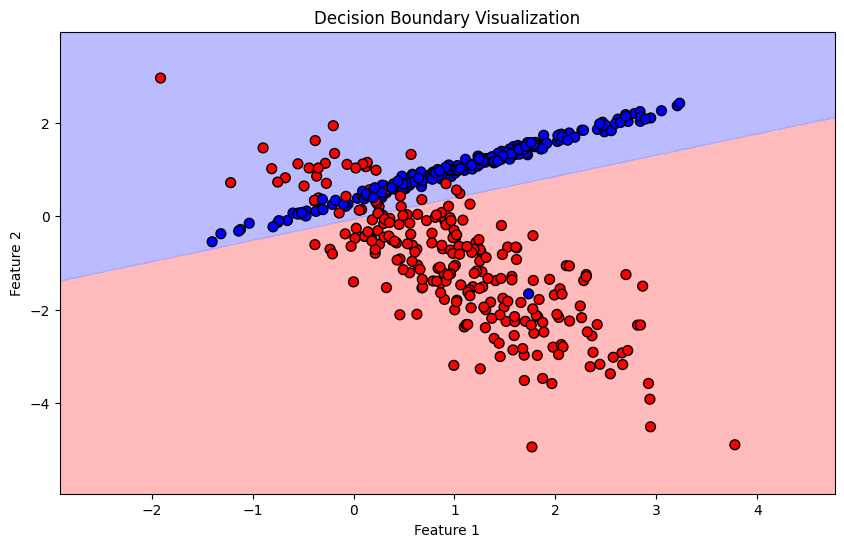

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


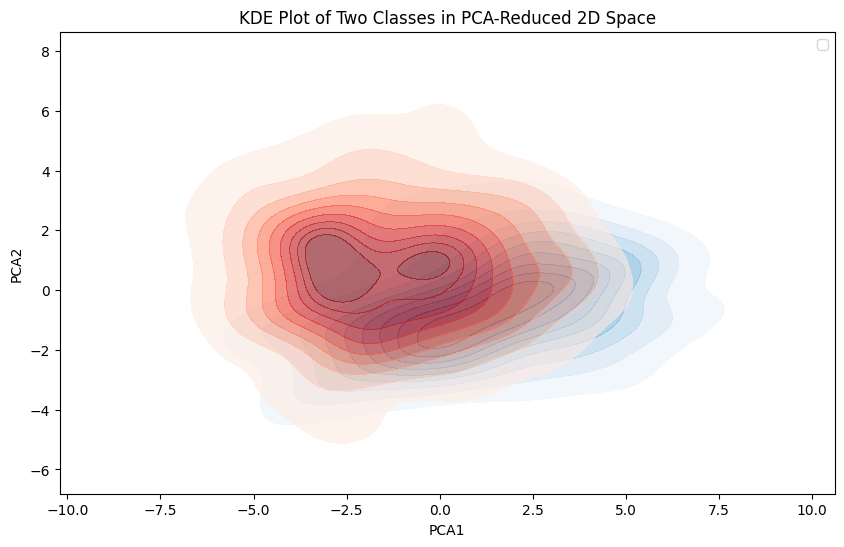

In [7]:
######################## Esto puede ayudar en un futuro, ahora no ####################################33












import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap

# Create a synthetic dataset with 2 features for visualization
X, y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)

# Define the classifier (you can try both k-NN and SVM)
# clf = KNeighborsClassifier(n_neighbors=15)  # k-NN
clf = SVC(kernel='linear', C=1.0)  # SVM

# Fit the model to the data
clf.fit(X, y)

# Set up the plot grid (meshgrid)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Predict over the grid to visualize decision boundaries
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Create a color map for plotting
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

# Plot the decision boundary and the dataset
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=50)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Decision Boundary Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification

# Create a synthetic dataset with many features
X, y = make_classification(n_samples=500, n_features=10, n_informative=5, random_state=42)

# Optionally convert to DataFrame for easier manipulation
df = pd.DataFrame(X)
df['class'] = y

# Step 1: Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Step 2: Create a DataFrame with the PCA-transformed features
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_pca['class'] = y

# Step 3: Create a KDE plot for both classes
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_pca[df_pca['class'] == 0], x='PCA1', y='PCA2', fill=True, cmap='Blues', alpha=0.6, label='Class 0')
sns.kdeplot(data=df_pca[df_pca['class'] == 1], x='PCA1', y='PCA2', fill=True, cmap='Reds', alpha=0.6, label='Class 1')

# Step 4: Customize and show the plot
plt.title('KDE Plot of Two Classes in PCA-Reduced 2D Space')
plt.legend()
plt.show()






#### **Label Algorithm**
Since this problem involves uncertain data, based on expert opinions and subjective assessments, our approach aims to maximize consensus while minimizing risk. To achieve this, we developed an algorithm that requires two mandatory input parameters: the list of nodule malignancy annotations and a standard deviation threshold (while computing $\sigma$, non-certain annotations are not taken into account ). Additionally, there are three optional parameters: the lower and upper limits, representing the minimum and maximum list lengths considered for labeling, and the final parameter is the allowed occurrence of "3"s within the array for it to be deemed eligible for labeling.

<div style="text-align: center;">
    <img src="images/frecuency_malignancy_annotations.png" alt="Frecuency_Malignancy_Annotations">
</div>

Taking into account the array lenght distribution shown above, the algorithm follows these core rules:

- **Benign Classification:** A nodule is classified as benign if the number "3" appears at most the occurrence of "3"s(by default 1) within the malignancy annotations. In addition, any other repeated values must be restricted to either "1" or "2." Furthermore, a nodule can also be labeled as benign if no "3"s are present, and the repeated values consist solely of "1"s or "2"s.

- **Malignant Classification:** A nodule is classified as malignant if the number "3" appears at most the occurrence of "3"s(by default 1). In this case, the remaining repeated values must be limited to either "4" or "5." A nodule can also be classified as malignant if there is no occurrence of "3," and the repeated values consist only of "4"s or "5"s.

- **Unlabeled Classification:** A nodule remains unlabeled if the number "3" appears more than the occurrence of "3"s. Additionally, the nodule cannot be classified as benign or malignant if the lower and upper array length conditions are not upheld, or if the criteria for either classification are not met (e.g., a mixture of values such as "1," "2," "4," and "5," or any other inconsistent pattern greater than $\sigma$ threshold).

In [64]:
df_merged.to_csv("final.csv")

### **Label Propagation vs. Label Spreading**
Semi-supervised learning is a branch of machine learning that combines supervised and unsupervised learning by using **both labeled and unlabeled** data to train artificial intelligence (AI) models for classification and regression tasks.

Semi-supervised learning methods are especially relevant in situations where obtaining a sufficient amount of labeled data is prohibitively difficult or expensive, but large amounts of unlabeled data are relatively easy to acquire.


- **Label propagation** is a graph-based semi-supervised learning algorithm that determines label assignments for unlabeled data by leveraging their proximity to labeled instances. This method relies on two core assumptions: the **smoothness assumption**, which suggests that points close in the feature space are likely to share the same label, and the **cluster assumption**, which posits that data points form distinct clusters with consistent labels.

The algorithm operates by constructing a fully connected graph, where nodes represent both labeled and unlabeled data points. The edges between nodes are weighted based on a predefined distance metric, such as Euclidean distance, with closer nodes having stronger connections. Starting with the labeled nodes, the labels are iteratively propagated to their neighboring unlabeled nodes, guided by the smoothness and cluster assumptions, until label convergence is achieved.

- **Label spreading** is an extension of label propagation that improves the label diffusion process using two key modifications. First, it constructs an affinity matrix based on the normalized graph Laplacian, which ensures a smoother and more balanced spread of labels by normalizing the graph's structure and controlling for variations in node connectivity. Second, it applies soft clamping to the labeled points, allowing their labels to slightly adjust during the propagation process, rather than keeping them fixed. This leads to a more flexible and stable label assignment for both labeled and unlabeled data.

<div style="text-align: center;">
    <img src="images/label_prop.png" alt="Label Propagation">
</div>



In [ ]:
from sklearn.semi_supervised import LabelPropagation,LabelSpreading
import numpy as np
from sklearn.preprocessing import StandardScaler


# Filtramos los datos no ambiguos (Malignancy != 3)
X_labeled = data[data["Malignancy_al"] != "Unlabeled"].drop(columns=["Malignancy_al","Patient","Nodule"])
y_labeled = data[data["Malignancy"] != "Unlabeled"]["Malignancy_al"]

# Filtramos los datos ambiguos (Malignancy == 3)
X_ambiguous = data[data["Malignancy_al"] == "Unlabeled"].drop(columns=["Malignancy_al","Patient","Nodule"])
y_ambiguous = data[data["Malignancy_al"] == "Unlabeled"]["Malignancy"]

# Imprimimos las dimensiones de los conjuntos de datos
print(X_labeled.shape, y_labeled.shape)

################### DATA TREATMENT ########################
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_labeled)
X_ambiguous_scaled = scaler.fit(X_ambiguous)
# Unimos los datos etiquetados y ambiguos en una única matriz de características
X = np.vstack([X_scaled, X_ambiguous_scaled])
# Creamos un vector de etiquetas donde las etiquetas ambiguas se marcan como -1 (desconocido)
y = np.hstack([y_labeled, [-1] * len(y_ambiguous)])

################### LABEL PROPAGATION ########################
# Definimos el modelo de Label Propagation
label_prop_model = LabelPropagation()

# Entrenamos el modelo con los datos
label_prop_model.fit(X, y)

# Predecimos las etiquetas para los datos ambiguos
y_pred_ambiguous = label_prop_model.transduction_[-len(y_ambiguous):]

# Mostramos las etiquetas predichas para los datos ambiguos
print("Predicted labels(Label Propagation) for ambiguous data:", y_pred_ambiguous)


################### LABEL SPREADING ########################


# Normalizamos los datos
scaler = StandardScaler()
X_labeled_scaled = scaler.fit_transform(X_labeled)
X_ambiguous_scaled = scaler.transform(X_ambiguous)

# Unimos los datos etiquetados y ambiguos
X_scaled = np.vstack([X_labeled_scaled, X_ambiguous_scaled])
y = np.hstack([y_labeled, [-1] * len(y_ambiguous)])

# Definimos y entrenamos el modelo de Label Spreading
label_spread_model = LabelSpreading()
label_spread_model.fit(X_scaled, y)

# Predecimos las etiquetas para los datos ambiguos
y_pred_ambiguous = label_spread_model.transduction_[-len(y_ambiguous):]
print("Predicted labels(Label Spreading) for ambiguous data:", y_pred_ambiguous)


### **Gaussian Mixture Models : Expectation Maximization (EM) algortithm**

In [1]:
import pandas as pd
data = pd.read_csv("final.csv")
data.head()

,Unnamed: 0,Patient,Nodule,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,...,Surface_area,Texture,Malignancy,Calcification,Internal_structure,Margin,Spiculation,Subtlety,Diameter,Lobulation
0,0,LIDC-IDRI-0001,I000,-392.712500,50.100000,3.813613e+07,4.334461,226.750000,3.543729,135.375000,...,2491.466573,4.75,5,6.0,1.0,3.25,4.25,5.0,32.755812,3.00
1,1,LIDC-IDRI-0002,I000,-798.528571,-568.957143,2.612477e+08,3.718732,121.830357,5.392035,-266.607143,...,2807.198994,1.50,5,6.0,1.0,1.50,1.00,1.5,30.781671,1.00
2,2,LIDC-IDRI-0003,I000,-796.625000,-505.437500,1.369430e+08,3.979841,163.687500,3.989364,-221.250000,...,1996.252117,1.00,2,6.0,1.0,2.00,1.00,1.0,31.664468,1.00
3,3,LIDC-IDRI-0003,I001,-513.500000,24.828571,3.709152e+07,4.595876,334.535714,2.345600,161.714286,...,2225.677350,4.00,5,6.0,1.0,3.25,3.00,5.0,31.001964,2.00
4,4,LIDC-IDRI-0003,I002,-606.900000,-251.675000,1.196120e+07,3.982101,225.375000,2.195547,-209.750000,...,321.183599,4.75,4,6.0,1.0,4.00,1.50,3.5,13.309155,1.75


### **PCA?**

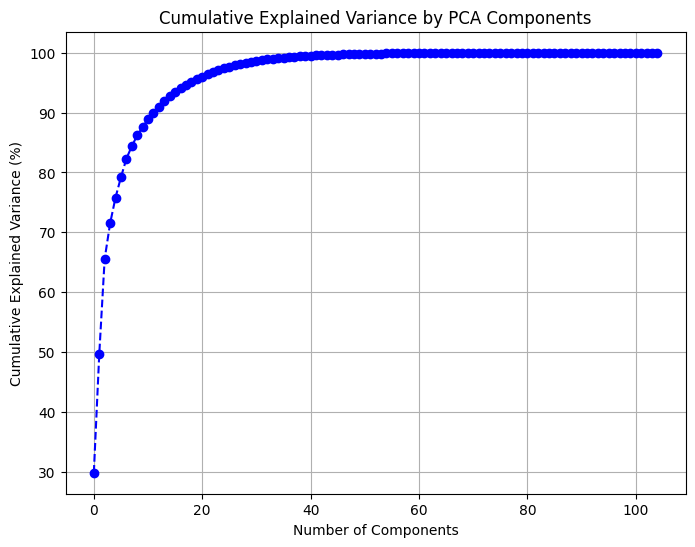

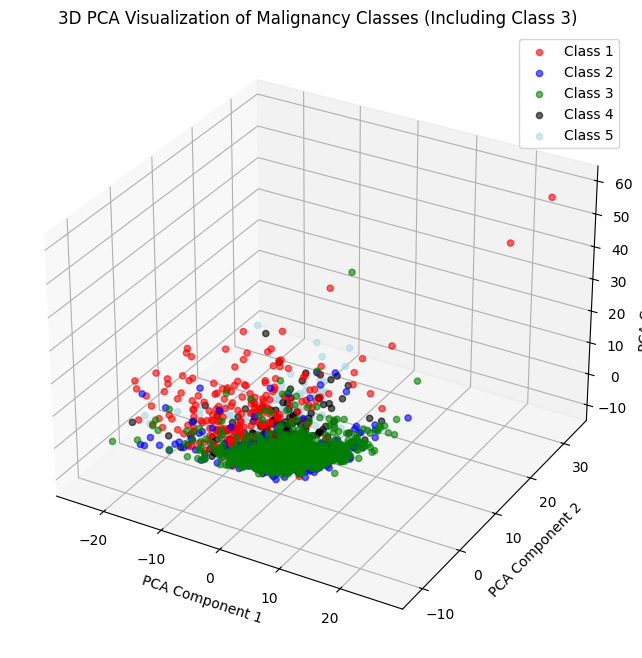

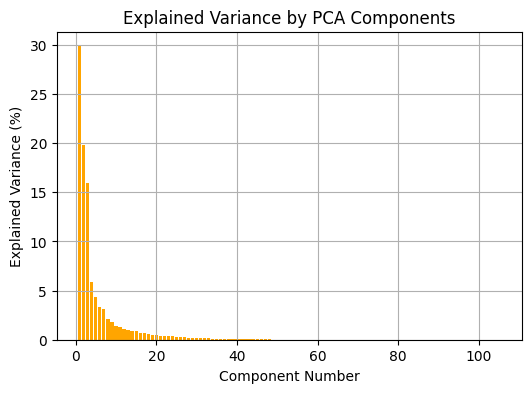

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Escalar los datos (opcional, pero recomendable para PCA)
X = data.drop(columns=["Patient", "Nodule", "Malignancy"])
y = data["Malignancy"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA con más componentes para poder ver el codo
pca_full = PCA()  # PCA sin límite para calcular todas las componentes
X_pca_full = pca_full.fit_transform(X_scaled)

# Obtener la varianza explicada por cada componente
explained_variance_full = pca_full.explained_variance_ratio_

# Gráfica del codo para la varianza explicada por cada componente
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(explained_variance_full) * 100, marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.grid(True)
plt.show()

# Ahora seleccionamos solo 3 componentes para la visualización 3D
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# Crear la gráfica 3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# Definir los colores para cada clase
colors = ['red', 'blue', 'green', 'black', 'lightblue']

# Graficar los puntos etiquetados según las clases de Malignancy en 3D
for label, color in zip([1, 2, 3, 4, 5], colors):  # Todas las clases de Malignancy
    ax.scatter(X_pca_3d[y == label, 0], X_pca_3d[y == label, 1], X_pca_3d[y == label, 2], 
               color=color, label=f'Class {label}', alpha=0.6)

# Etiquetas y título para el gráfico 3D
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title('3D PCA Visualization of Malignancy Classes (Including Class 3)')
plt.legend()
plt.grid(True)
plt.show()

# Mostrar la varianza explicada acumulada en la gráfica del codo
plt.figure(figsize=(6,4))
plt.bar(range(1, len(explained_variance_full) + 1), explained_variance_full * 100, color='orange')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Component Number')
plt.ylabel('Explained Variance (%)')
plt.grid(True)
plt.show()


### SMOTE

In [19]:
data[data['Malignancy'] != 3]["Malignancy"].value_counts()

Malignancy
2    481
4    343
1    316
5    221
Name: count, dtype: int64

In [31]:
print(X.shape,y.shape)

(1361, 105) (1361,)


In [41]:
# Instalar imblearn si no lo tienes
# !pip install imbalanced-learn
# !pip install xgboost

import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Suponiendo que el DataFrame original 'data' ya existe y tiene la columna 'Malignancy' como target

# Separar características y etiquetas (eliminar clase 3)
X = data[data['Malignancy'] != 3].drop(columns=['Malignancy', 'Nodule', 'Patient'])
y = data[data['Malignancy'] != 3]['Malignancy']

# Mapear las clases
class_mapping = {1: 0, 2: 1, 4: 2, 5: 3}
y = y.map(class_mapping)

# Verificar las clases presentes
print("Clases únicas en el conjunto filtrado:", y.unique())

# Contar el número de muestras por clase
class_counts = y.value_counts()
print("Número de muestras por clase antes de SMOTE:")
print(class_counts)

# Ajustar el sampling_strategy
max_count = class_counts.max()  # Obtener el número máximo de muestras de una clase
sampling_strategy = {label: max_count for label in class_counts.index}

# Aplicar SMOTE para generar datos sintéticos de las clases (0, 1, 2, 3)
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Dividir los datos sintéticos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Entrenar un modelo XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de datos original
y_pred = xgb_model.predict(X)

# Ajustar las predicciones para el reporte (revertir el mapeo)
# Convertir y_pred (0, 1, 2, 3) de vuelta a (1, 2, 4, 5)
reverse_mapping = {0: 1, 1: 2, 2: 4, 3: 5}
y_pred_original = [reverse_mapping[p] for p in y_pred]

# Evaluar el rendimiento del modelo usando los datos originales
conf_matrix = confusion_matrix(data[data['Malignancy'] != 3]['Malignancy'], y_pred_original, labels=[1, 2, 4, 5])  # Incluir las clases originales
class_report = classification_report(data[data['Malignancy'] != 3]['Malignancy'], y_pred_original, labels=[1, 2, 4, 5])

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Clases únicas en el conjunto filtrado: [3 1 2 0]
Número de muestras por clase antes de SMOTE:
Malignancy
1    481
2    343
0    316
3    221
Name: count, dtype: int64


C:\Users\34660\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [00:09:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
 [[310   6   0   0]
 [  1 467  12   1]
 [  1  10 314  18]
 [  0   1   8 212]]

Classification Report:
               precision    recall  f1-score   support

           1       0.99      0.98      0.99       316
           2       0.96      0.97      0.97       481
           4       0.94      0.92      0.93       343
           5       0.92      0.96      0.94       221

    accuracy                           0.96      1361
   macro avg       0.95      0.96      0.96      1361
weighted avg       0.96      0.96      0.96      1361



In [40]:
print(data[data['Malignancy'] != 3]['Malignancy'])
print(y_pred_original)

0       5
1       5
2       2
3       5
4       4
       ..
2570    4
2571    5
2572    5
2573    2
2574    2
Name: Malignancy, Length: 1361, dtype: int64
[5, 5, 2, 5, 4, 4, 1, 2, 2, 2, 5, 5, 2, 2, 2, 2, 4, 1, 2, 1, 2, 1, 1, 2, 1, 4, 4, 2, 4, 5, 4, 5, 5, 4, 5, 2, 4, 5, 4, 5, 2, 2, 1, 2, 5, 4, 2, 2, 2, 2, 2, 5, 2, 2, 4, 5, 4, 2, 4, 5, 4, 1, 1, 1, 1, 1, 4, 1, 4, 2, 4, 4, 5, 2, 1, 5, 4, 4, 2, 1, 5, 2, 5, 2, 4, 2, 2, 2, 2, 2, 4, 5, 2, 4, 4, 2, 5, 4, 4, 5, 4, 4, 5, 2, 2, 5, 5, 5, 4, 4, 5, 2, 5, 4, 5, 5, 2, 5, 1, 5, 5, 4, 4, 4, 4, 2, 4, 4, 4, 2, 4, 2, 5, 1, 4, 5, 5, 5, 5, 4, 4, 1, 5, 4, 5, 4, 5, 5, 1, 2, 2, 2, 2, 5, 1, 1, 2, 5, 4, 1, 2, 1, 2, 4, 4, 5, 4, 4, 4, 2, 4, 2, 5, 2, 4, 1, 1, 2, 2, 5, 4, 5, 5, 2, 4, 2, 5, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 2, 2, 2, 2, 2, 2, 2, 4, 4, 2, 4, 2, 2, 5, 1, 4, 4, 4, 4, 5, 4, 4, 5, 1, 2, 2, 2, 2, 1, 1, 4, 4, 1, 5, 5, 5, 5, 4, 2, 1, 4, 4, 2, 1, 2, 4, 2, 4, 4, 4, 2, 5, 5, 2, 2, 2, 2, 5, 4, 4, 4, 5, 4, 1, 1, 4, 1, 4, 2, 2, 4, 4, 5, 2, 2, 1, 1, 4, 5, 5, 4, 2, 2, 2, 5

Predicted labels for ambiguous data: [1 1 1 ... 1 1 1]


Predicted labels for ambiguous data: [2 2 2 ... 2 2 2]


In [ ]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.semi_supervised import LabelSpreading
from sklearn.preprocessing import StandardScaler

# Cargar los datos
df = data

# Eliminar las columnas 'Patient' y 'Nodule'
X = df.drop(columns=['Patient', 'Nodule', 'Malignancy'])

# Definir la variable objetivo 'y' (Malignancy)
y = df['Malignancy']

# Eliminar las filas donde y == 3
X_labeled = X[y != 3]
y_labeled = y[y != 3]

# Transformar el problema a binario: True si y >= 2, False si y < 2
y_binary = (y_labeled >= 2).astype(int)

# Dividir los datos en entrenamiento (80%) y prueba (20%) - Hold-out
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

# Crear el modelo XGBoost para clasificación
xgboost_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Entrenar el modelo en el conjunto de entrenamiento inicial (solo datos no ambiguos)
xgboost_model.fit(X_train, y_train)

# Evaluar la precisión inicial
y_pred_initial = xgboost_model.predict(X_test)
initial_accuracy = accuracy_score(y_test, y_pred_initial)
print(f"Initial Test Accuracy: {initial_accuracy}")

# Predecir los datos ambiguos usando Label Spreading
X_ambiguous = X[y == 3]  # Datos ambiguos
scaler = StandardScaler()  # Escalamiento de características
X_labeled_scaled = scaler.fit_transform(X_labeled)
X_ambiguous_scaled = scaler.transform(X_ambiguous)

# Usar Label Spreading para propagar etiquetas a los datos ambiguos
label_spread_model = LabelSpreading()
label_spread_model.fit(np.vstack([X_labeled_scaled, X_ambiguous_scaled]), np.hstack([y_binary, [-1] * len(X_ambiguous)]))

# Obtener las etiquetas predichas para los datos ambiguos
y_pred_ambiguous = label_spread_model.transduction_[-len(X_ambiguous):]

# Inicializar la lista para guardar la evolución de la precisión
accuracies = [initial_accuracy]

# Bucle para agregar los ejemplos predichos por el label spreader uno por uno
for i in range(len(X_ambiguous)):
    # Añadir un ejemplo ambiguo predicho al conjunto de entrenamiento
    X_new = X_ambiguous.iloc[[i]]
    y_new = y_pred_ambiguous[i]
    
    # Escalar el nuevo ejemplo
    X_new_scaled = scaler.transform(X_new)
    
    # Añadir el ejemplo al conjunto de entrenamiento
    X_train = np.vstack([X_train, X_new_scaled])
    y_train = np.hstack([y_train, y_new])
    
    # Reentrenar el modelo XGBoost
    xgboost_model.fit(X_train, y_train)
    
    # Evaluar el rendimiento del modelo en el conjunto de prueba
    y_pred = xgboost_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Guardar la precisión actual
    accuracies.append(accuracy)
    print(f"Iteration {i+1}, Test Accuracy: {accuracy}")




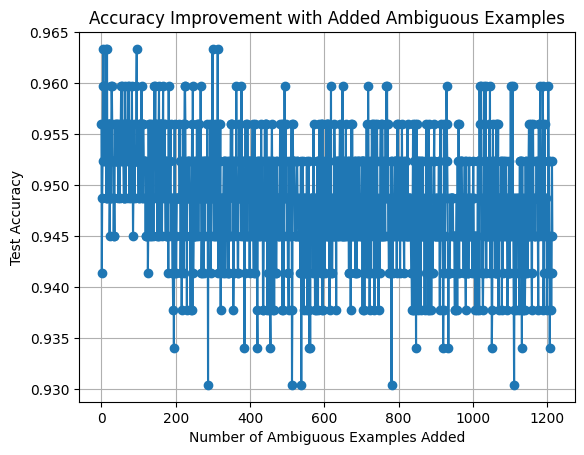

In [27]:
# Plotear la evolución de la precisión
plt.plot(range(len(accuracies)), accuracies, marker='o')
plt.title("Accuracy Improvement with Added Ambiguous Examples")
plt.xlabel("Number of Ambiguous Examples Added")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()

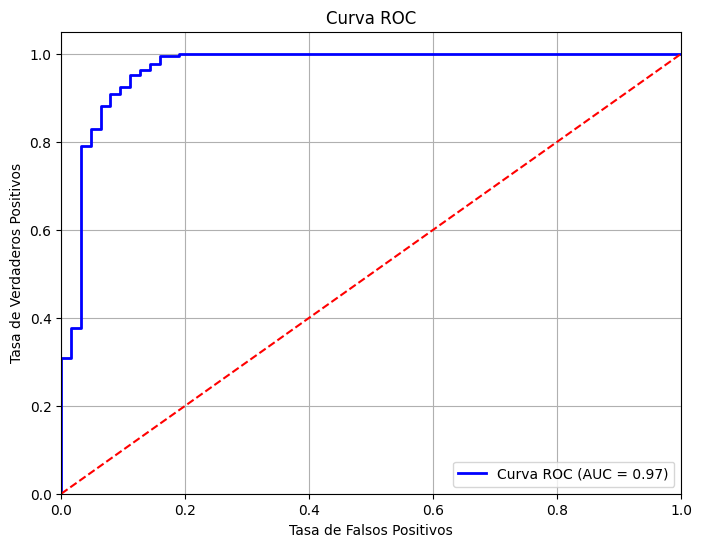

<Figure size 1000x600 with 0 Axes>

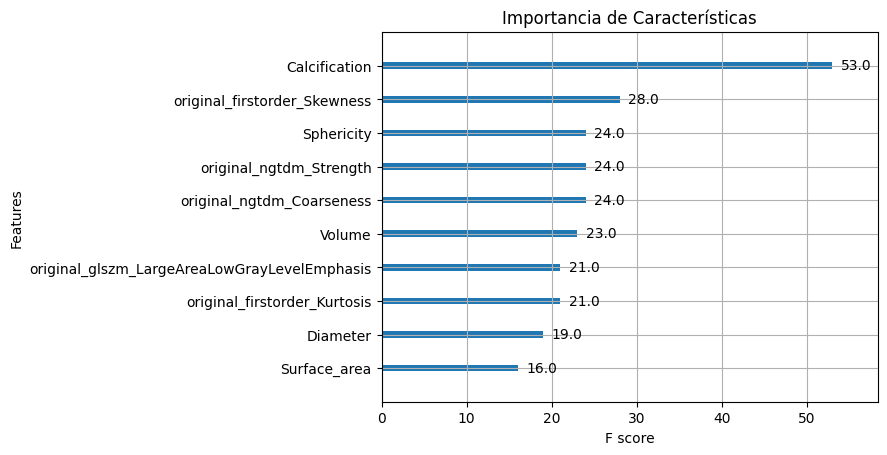

In [45]:
# Calcular la curva ROC
y_pred_proba = xgboost_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Gráfico de la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Gráfico de importancia de características
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgboost_model, importance_type='weight', max_num_features=10)
plt.title('Importancia de Características')
plt.show()

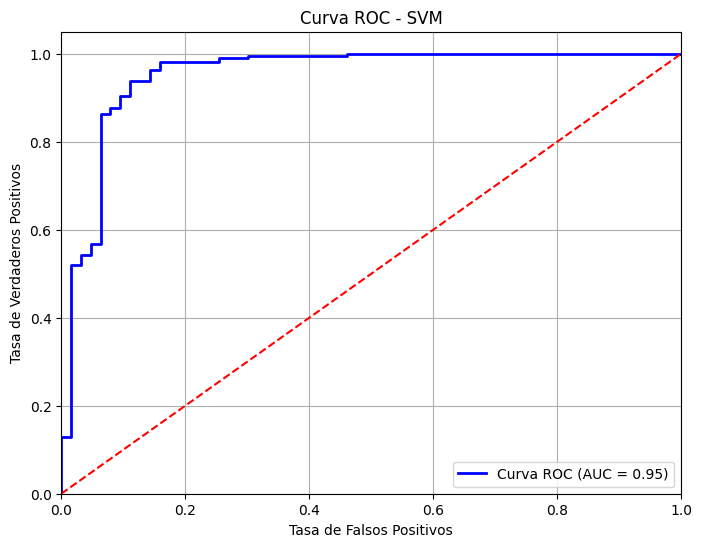

Test Accuracy: 0.945054945054945

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.83      0.87        63
           1       0.95      0.98      0.96       210

    accuracy                           0.95       273
   macro avg       0.94      0.90      0.92       273
weighted avg       0.94      0.95      0.94       273



In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler

# Cargar los datos
df = df_merged

# Eliminar las columnas 'Patient' y 'Nodule'
X = df.drop(columns=['Patient', 'Nodule', 'Malignancy'])
y = df['Malignancy']

# Filtrar donde y != 3
X_filtered = X[y != 3]
y_filtered = y[y != 3]

# Convertir a binario
y_binary = (y_filtered >= 2).astype(int)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

# Normalizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo SVM
svm_model = SVC(probability=True, random_state=42)

# Entrenar el modelo
svm_model.fit(X_train_scaled, y_train)

# Predicciones en el conjunto de prueba
y_pred = svm_model.predict(X_test_scaled)
y_pred_proba = svm_model.predict_proba(X_test_scaled)[:, 1]  # Probabilidades de clase positiva

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Gráfico de la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - SVM')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Mostrar resultados
print(f"Test Accuracy: {accuracy}")
print(f"\nClassification Report:\n{classification_rep}")
